In [1]:
import wrds
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import os
import sys
sys.path.insert(1, '../src/')
from pathlib import Path
import load_option_data_01 as l1
import filter_option_data_01 as f1
import bsm_pricer as bsm
import config
WRDS_USERNAME = Path(config.WRDS_USERNAME)
DATA_DIR = Path(config.DATA_DIR)

In [3]:
def pull_option_price(wrds_username, year=2012): 
	db = wrds.Connection(wrds_username=wrds_username)

	sql_query = f"""
					SELECT 
						*
					FROM
						optionm_all.opprcd{year} AS a
					WHERE
						a.secid=108105;
				"""
		
	optm_df = db.raw_sql(sql_query, date_cols = ["date"])

	db.close()

	return optm_df

def pull_all_option_price(wrds_username, last_year=2012): 
	db = wrds.Connection(wrds_username=wrds_username)

	optm_df = []

	for year in range(1996,last_year+1):
		sql_query = f"""
						SELECT 
							a.date, a.exdate, a.cp_flag, a.strike_price
						FROM
							optionm_all.opprcd{year} AS a
						WHERE
							a.secid=108105;
					"""
		
		optm = db.raw_sql(sql_query, date_cols = ["date"])

		optm_df.append(optm)
		
	db.close()

	optm_df = pd.concat(optm_df)
	
	return optm_df


def pull_all_req_data(wrds_username, start_year=1996, end_year=2012): 
	db = wrds.Connection(wrds_username=wrds_username)

	optm_df = []

	for year in range(start_year, end_year+1):
		sql_query = f"""
						SELECT 
							a.date, a.exdate, a.cp_flag, a.strike_price, a.best_bid, a.best_offer,a.volume,
							b.open, b.close, a.impl_volatility, c.tb_m3
						FROM
							optionm_all.opprcd{year} AS a
						JOIN 
							optionm_all.secprd{year} AS b ON a.date = b.date AND a.secid = b.secid
						JOIN 
							frb_all.rates_daily AS c ON c.date = a.date 
						WHERE
							a.secid=108105 AND a.date <= '2012-01-31';
					"""
		
		optm = db.raw_sql(sql_query, date_cols = ["date"])

		optm_df.append(optm)
		
	db.close()

	optm_df = pd.concat(optm_df)
	
	return optm_df

def pull_Opt_Sec_info_WRDS(wrds_username = WRDS_USERNAME, start = '1996-01-04', end = '2012-01-31'): 
	#https://wrds-www.wharton.upenn.edu/pages/get-data/option-suite-wrds/us-option-level-output/
	sql_query = f"""
		SELECT  
			a.*, c.tb_m3
		FROM
			beta.wrdsapps_optionsig  AS a
		JOIN 
			frb_all.rates_daily AS c ON c.date = a.date 
		WHERE
			(a.secid = 108105) 
		AND 
			(a.date <= \'{end}\') 
		AND 
			(a.date >= \'{start}\')
		LIMIT 1000
	""" 
	#LIMIT 1000
	db = wrds.Connection(wrds_username=wrds_username)
	optm = db.raw_sql(sql_query, date_cols = ["date", "exdate"])
	db.close()
	return optm

In [2]:
optm_df = pd.read_parquet(DATA_DIR / "pulled" / "data_1996-01_2012-01.parquet")
# optm_df = pd.read_parquet(DATA_DIR / "pulled" / "data_2012-02_2023-12.parquet")

<Axes: xlabel='date'>

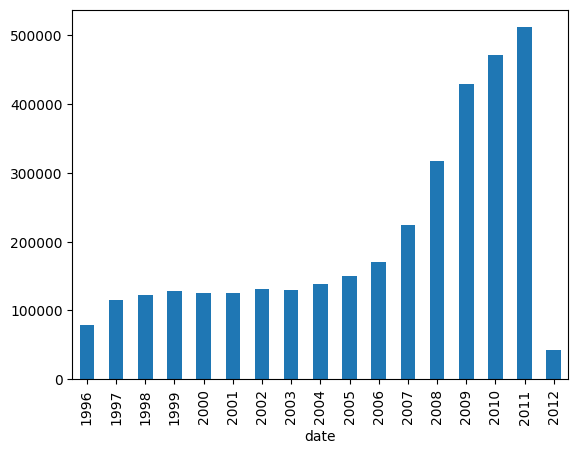

In [7]:
optm_df['date'].dt.year.value_counts().sort_index().plot(kind='bar')

In [4]:
print(optm_df.shape)
print(optm_df['cp_flag'].value_counts().to_dict())

(3410580, 14)
{'P': 1706360, 'C': 1704220}


In [5]:
optm_df['option_price'] = (optm_df['best_bid'] + optm_df['best_offer'])/2
optm_df['index_price'] = (optm_df['open'] + optm_df['close'])/2

### Level 1 filters

#### Identical Filter:
The OptionMetrics data set contain duplicate observations,
defined as two or more quotes with identical option type, strike, expiration
date, and price. In each such case, we eliminate all but one of the quotes.

In [5]:
# Assuming 'df' is your DataFrame

def delete_identical_filter(df):
    columns_to_check = ['cp_flag', 'strike_price','date', 'exdate', 'best_offer']

    # Drop duplicates based on specified columns
    df = df.drop_duplicates(subset=columns_to_check, keep='first')

    return df

In [17]:
optm_l1_df = pd.read_parquet(DATA_DIR / "pulled" / 'data_199601_201201_L1filter.parquet')
optm_l1_df.shape

(3138492, 16)

In [18]:
optm_df.shape[0] - optm_l1_df.shape[0]

272088

#### Identical Except Price Filter:
There are a few sets of quotes with identical
terms (type, strike, and maturity) but different prices. When this occurs, we
keep the quote whose T-bill-based implied volatility is closest to that of its
moneyness neighbors, and delete the others.

NEXT STEPS - determine moneyness neighbors >> only 18 duplicates so 9 deleted versus 11 in paper

In [198]:
def delete_identical_xprice_filter(df):
    columns_to_check = ['cp_flag', 'strike_price','date', 'exdate']

    # Drop duplicates based on specified columns
    df = df.drop_duplicates(subset=columns_to_check, keep='first')

    return df

In [199]:
columns_to_check = ['cp_flag', 'strike_price','date', 'exdate']

identical_df = optm_l1_df[optm_l1_df.duplicated(columns_to_check,keep=False)].sort_values(columns_to_check)

identical_df.shape

(20, 16)

In [200]:
identical_df = optm_l1_df[optm_l1_df.duplicated(columns_to_check,keep='first')].sort_values(columns_to_check)
identical_df.shape

(10, 16)

In [201]:
optm_l1_df = delete_identical_xprice_filter(optm_l1_df)
print(optm_l1_df.shape)

(3410570, 16)


In [202]:
def delete_zero_bid(df):
    df=df.loc[df['best_bid'] > 0]
    return df

In [203]:
optm_l1_df = delete_zero_bid(optm_l1_df)

In [204]:
optm_df.shape[0] - optm_l1_df.shape[0]

272088

In [205]:
optm_l1_df.shape[0]

3138492

### Level 2 filters
* “Days to Maturity <7 or >180” Filter
* “IV<5% or >100%” Filter
* “Moneyness <0.8 or >1.2” Filter
* “Implied Interest Rate <0” Filter

In [19]:
def clear_module_cache(module_name):
    if module_name in sys.modules:
        del sys.modules[module_name]

In [34]:
clear_module_cache('filter_option_data_01')
import filter_option_data_02 as f2
import filter_option_data_01 as f1

In [21]:
# optm_l2_df = pd.read_parquet(DATA_DIR / 'pulled' / 'data_199601_201201_L2filter.parquet')

In [24]:
optm_l2_df = optm_l1_df.copy()
optm_l2_df['tb_m3'] = optm_l2_df['tb_m3'].ffill()

In [25]:
optm_l2_df = f2.filter_time_to_maturity(optm_l2_df)
optm_l2_df.shape

(1840763, 18)

In [26]:
optm_l2_df.shape[0] - optm_l2_df.loc[((optm_l2_df['impl_volatility']>=0.05) & (optm_l2_df['impl_volatility']<=1)) | (optm_l2_df['impl_volatility'].isna())].shape[0]

16432

In [23]:
clear_module_cache('bsm_pricer')
import bsm_pricer as bsm

In [46]:
optm_l2_df['iv_guess'] = optm_l2_df['impl_volatility'].fillna(optm_l2_df['tb_m3'])


In [56]:
bsm.calc_implied_volatility(test['best_bid'], test['sec_price'], test['strike_price'], test['time_to_matility_yrs'], test['tb_m3'], test['cp_flag'], initial_guess=test['iv_guess'])

1e-16

In [74]:
def calc_implied_volatility_wrapper(row):
    try:
        implied_volatility = bsm.calc_implied_volatility(row['best_bid'], row['sec_price'], row['strike_price'], row['time_to_matility_yrs'], row['tb_m3'], row['cp_flag'], initial_guess=row['iv_guess'])
        print(f"Implied Volatility {row.name}: {implied_volatility}")
        return implied_volatility
    except ValueError as e:
        # Handle the error as per your requirement, you can print the error or return a default value
        print(f"Error for row {row.name}: {e}")
        return 0

In [ ]:
optm_l2_df['impl_vol_bsm'] = optm_l2_df.apply(calc_implied_volatility_wrapper, axis=1)

In [83]:
iv_len = optm_l2_df.loc[(optm_l2_df['impl_volatility']>=0.05) & (optm_l2_df['impl_volatility']<=1.00)].shape[0]

In [29]:
optm_l2_df = f2.filter_moneyness(optm_l2_df)
optm_l2_df.shape[0]

1274299

In [38]:
df = l1.load_all_optm_data(DATA_DIR)
print(df.shape[0])
optm_l1_df = f1.appendixBfilter_level1(df)[0]
print(optm_l1_df.shape[0])

Reading from file: C:\Users\harri\repos\finm-32900_final_project\data\pulled\data_1996-01_2012-01.parquet
Loading Data took 0.5 seconds
3410580
3138492


In [42]:
optm_l2_df = f2.filter_time_to_maturity(optm_l1_df)
optm_l2_df = f2.filter_iv(optm_l2_df)
optm_l2_df = f2.filter_moneyness(optm_l2_df)
optm_l2_df.shape[0]

1274104

In [44]:
3138336-1297634-12676-553947-177246-20059

1076774